In [4]:
!pip -V

pip 23.3.1 from /root/feature-map-experiments/.cenv/lib/python3.10/site-packages/pip (python 3.10)


# .init

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import os
import sys
from pathlib import Path
workspace_dir = Path.cwd()
if not (workspace_dir / '.git').exists():
    workspace_dir = workspace_dir.parent


module_path = str(workspace_dir.resolve()) # os.path.abspath(os.path.join('..'))
print(f'workspace dir: {module_path}')

# Fixes a periodic issue with locating local packages.
if module_path not in sys.path:
    sys.path.append(module_path)

workspace dir: /root/feature-map-experiments


In [7]:
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np

In [3]:
# import openslide
slides_dir = workspace_dir / 'WSI'
# slide_path = slides_dir / 'C-16-098.svs'
slide_path = slides_dir / 'C-17-036 - 2021-07-15 215134.ndpi'

print(f'{slide_path}')
# slide = openslide.OpenSlide(str(slide_path))

'/root/feature-map-experiments/WSI/C-16-098.svs'

/root/feature-map-experiments/WSI/C-17-036 - 2021-07-15 215134.ndpi


'/root/feature-map-experiments/WSI/C-16-098.svs'

In [25]:
slide_path.suffix[1:]

'ndpi'

# OpenSlide

In [6]:
import openslide

# Открываем изображение
slide = openslide.OpenSlide(str(slide_path))
metadata = slide.properties

print(metadata)


<_PropertyMap {'hamamatsu.CCD.Height': '-1', 'hamamatsu.CCD.Width': '5301', 'hamamatsu.Calibration.Version': '500', 'hamamatsu.Coarse.Focus.Pitch': '5000', 'hamamatsu.Coarse.Focus.Travel': '10000', 'hamamatsu.Condenser.NA': 'ÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿ5', 'hamamatsu.Condition2.CCD.Height': '0', 'hamamatsu.Condition2.CCD.Width': '0', 'hamamatsu.Condition2.Lane.Shift.Amount': '0', 'hamamatsu.Condition2.Objective.Lens.Magnificant': '1.01857e-312', 'hamamatsu.Condition2.Stage.Offset': '0,0,0', 'hamamatsu.Condition2.Vertical.Offset': '0,0', 'hamamatsu.Created': '2017/11/07', 'hamamatsu.Exposure.Barcode.Macro': '67', 'hamamatsu.Exposure.CassetteBarcode': '50', 'hamamatsu.Exposure.Slide.Darkfield.Macro': '-1', 'hamamatsu.Exposure.Slide.Macro': '8', 'hamamatsu.Fine.Focus.Pitch': '250', 'hamamatsu.Fine.Focus.Travel': '400', 'hamamatsu.FocalPlane.LeftBottom': '299425,246549,115283', 'hamamatsu.FocalPlane.LeftTop': '299425,46549,115334', 'hamamatsu.FocalPlane.RightBottom': '699425,246549,115

width=134400 height=64512


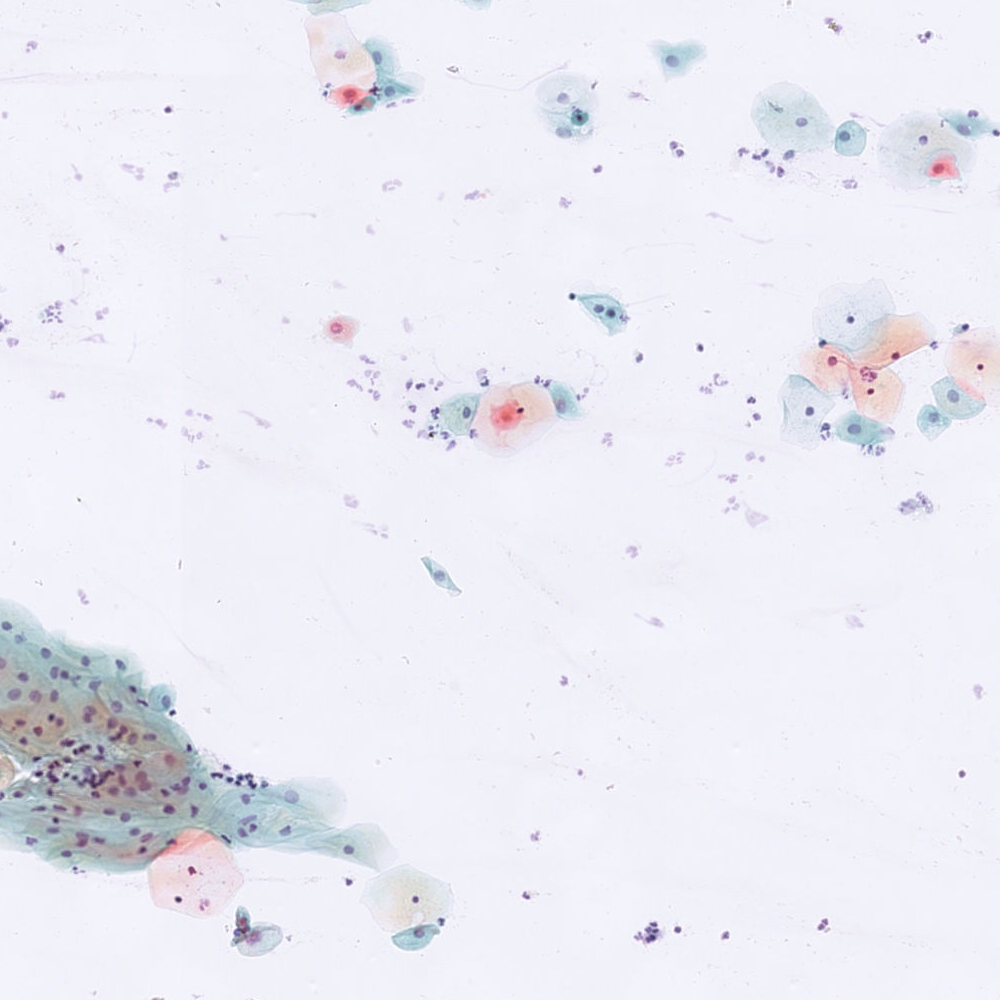

In [24]:
# Получаем размеры изображения
width, height = slide.level_dimensions[0]

print(f'{width=} {height=}')

# Получаем размер патча
patch_width, patch_height = 1000, 1000

# Получаем позицию патча
x, y = 30000, 55000

# Вырезаем патч
patch = slide.read_region((x, y), 2, (patch_width, patch_height))
# Image.fromarray(np.array(patch)).convert('RGB').show()
patch.convert('RGB')

# SlideIO 

In [5]:
import slideio

slide = slideio.open_slide(str(slide_path),'NDPI')
num_scenes = slide.num_scenes
scene = slide.get_scene(0)
print(f'{num_scenes=}, {scene.name=}, {num_scenes=}, {scene.rect=}, {scene.num_channels=}, {scene.resolution=}, {scene.magnification}')

RuntimeError: /src/src/slideio/drivers/ndpi/ndpitiffmessagehandler.cpp:57:TIFF Error:Directory count exceeded 65535 limit, giving up on counting.

In [12]:
raw_string = slide.raw_metadata
raw_string.split("|")

['Aperio Image Library v12.0.15 \r\n156464x81772 [0,100 153384x81672] (240x240) JPEG/RGB Q=70',
 'AppMag = 40',
 'StripeWidth = 2032',
 'ScanScope ID = SS7543',
 'Filename = C-16-098',
 'Date = 06/23/21',
 'Time = 00:15:17',
 'Time Zone = GMT+09:00',
 'User = 36624229-2cba-4aa8-a149-ebdb6adf0861',
 'Parmset = MK1',
 'MPP = 0.2522',
 'Left = 16.534300',
 'Top = 22.633415',
 'LineCameraSkew = -0.000800',
 'LineAreaXOffset = 0.015493',
 'LineAreaYOffset = -0.010352',
 'Focus Offset = 0.000000',
 'ImageID = 1042670',
 'Exposure Time = 45',
 'Exposure Scale = 0.000001',
 'DisplayColor = 0',
 'SessonMode = NR',
 'BestFocusLayer = 1',
 'OriginalWidth = 156464',
 'OriginalHeight = 81772',
 'ICC Profile = ScanScope v1',
 'TotalDepth = 1.000000']

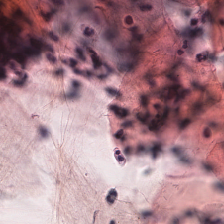

In [13]:



# image = scene.read_block((5000, 5000, 5000, 5000), size=(500,0))
image = scene.read_block((39000, 39000, 500, 500), size=(224,0))

# plt.imshow(image)
Image.fromarray(image).convert('RGB').show()

In [17]:
def extract_patches_from_slide(scene: slideio.Scene, start, end, patch_size, step):
    """
    Извлекает патчи из изображения заданного размера и с заданным шагом по x и y.

    :param slide: slideio.Scene
    :param patch_size: Размер патча (ширина, высота).
    :param step_x: Шаг по горизонтали.
    :param step_y: Шаг по вертикали.
    :return: Двумерная матрица патчей (numpy array).
    """
    patches = []
    width, height = (scene.rect[2], scene.rect[3])
    patch_width, patch_height = patch_size

    step_x, step_y = step

    start_x, start_y = start
    end_x, end_y = end

    for y in range(start_y, min(end_y, height - patch_height + 1), step_y):
        row_patches = []
        for x in range(start_x, min(end_x, width - patch_width + 1), step_x):
            patch = scene.read_block((x, y, patch_width, patch_height), size=(224,0))
            # patch = image.crop((x, y, x + patch_width, y + patch_height))
            row_patches.append(np.array(patch))
        patches.append(row_patches)

    return np.array(patches)

In [32]:
p = extract_patches_from_slide(scene, start=(38000, 38000), end=(44000,44000), patch_size=(400,400), step=(400,400))

In [33]:
print(f'{p.shape[0:2]=}')

p_mat_shape = p.shape[0:2]
flat_p = p.reshape(-1, *p.shape[2:])
flat_p.shape

p.shape[0:2]=(15, 15)


(225, 224, 224, 3)

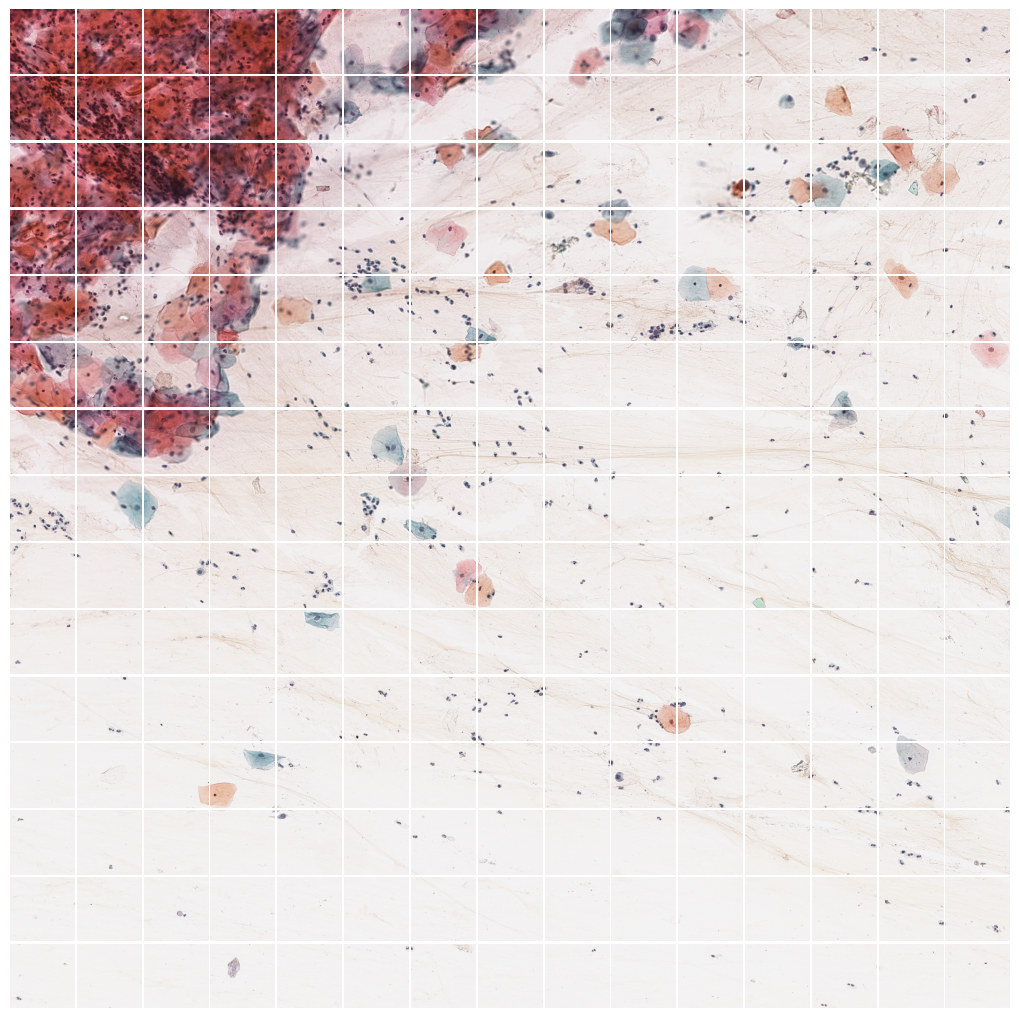

In [34]:
from fmc.plot_utils import display_image_grid
display_image_grid(flat_p, p_mat_shape)